In [1]:
# --- Importar Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para guardar el modelo
import warnings

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# --- Modelos ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# --- Preprocesamiento ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Métricas ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# --- Cargar Datos ---
try:
    # Asegúrate de que los archivos estén en la misma carpeta o ajusta la ruta
    train_df = pd.read_csv('datos/train.csv')
    test_df = pd.read_csv('datos/test.csv')
    
    print("Archivos 'train.csv' y 'test.csv' cargados exitosamente.")
    print(f"Muestras de entrenamiento: {len(train_df)}")
    print(f"Muestras de prueba: {len(test_df)}")
    
except FileNotFoundError:
    print("Error: No se encontraron los archivos 'train.csv' o 'test.csv'.")
    print("Por favor, asegúrate de que estén en la carpeta 'datos/'.")

# --- Inspección Rápida ---
print("\n--- Columnas y tipos de datos (Train) ---")
train_df.info()

print("\n--- Primeras filas (Train) ---")
display(train_df.head())

Archivos 'train.csv' y 'test.csv' cargados exitosamente.
Muestras de entrenamiento: 287
Muestras de prueba: 72

--- Columnas y tipos de datos (Train) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   287 non-null    object 
 1   Age                      287 non-null    int64  
 2   Occupation               287 non-null    object 
 3   Sleep Duration           287 non-null    float64
 4   Quality of Sleep         287 non-null    int64  
 5   Physical Activity Level  287 non-null    int64  
 6   BMI Category             287 non-null    object 
 7   Blood Pressure           287 non-null    object 
 8   Heart Rate               287 non-null    int64  
 9   Daily Steps              287 non-null    int64  
 10  Sleep Disorder           116 non-null    object 
 11  Stress_Category          287 non-n

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Stress_Category
0,Male,44,Salesperson,6.3,6,45,Overweight,130/85,72,6000,Insomnia,ESTRESADO
1,Female,52,Accountant,6.5,7,45,Overweight,130/85,72,6000,Insomnia,ESTRESADO
2,Female,38,Accountant,7.1,8,60,Normal,115/75,68,7000,NaN,ESTRES_MODERADO
3,Female,54,Engineer,8.4,9,30,Normal,125/80,65,5000,NaN,ESTRES_MODERADO
4,Male,44,Salesperson,6.4,6,45,Overweight,130/85,72,6000,Insomnia,ESTRESADO


ColumnTransformer

In [2]:
print("\n--- Paso 1: Ingeniería y Preprocesamiento ---")

# --- 1.1: Función para 'Blood Pressure' ---
def engineer_bp(df):
    # Dividir la columna 'Blood Pressure'
    bp_split = df['Blood Pressure'].str.split('/', expand=True).astype(float)
    df['Systolic_BP'] = bp_split[0]
    df['Diastolic_BP'] = bp_split[1]
    # Eliminar la columna original
    df = df.drop('Blood Pressure', axis=1)
    return df

print("Aplicando ingeniería a 'Blood Pressure'...")
X_train_featured = engineer_bp(train_df.drop('Stress_Category', axis=1))
X_test_featured = engineer_bp(test_df.drop('Stress_Category', axis=1))

# --- 1.2: Mapeo de la Variable Objetivo (y) ---
target_map = {'ESTRESADO': 1, 'ESTRES_MODERADO': 0}
y_train = train_df['Stress_Category'].map(target_map)
y_test = test_df['Stress_Category'].map(target_map)

print("Variable objetivo mapeada a 1 (Estresado) y 0 (Moderado).")

# --- 1.3: Definir listas de columnas ---
# Columnas numéricas (incluyendo las nuevas de BP)
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 
                    'Physical Activity Level', 'Heart Rate', 'Daily Steps',
                    'Systolic_BP', 'Diastolic_BP']

# Columnas categóricas
categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

# Guardamos todas las características para usarlas después
ALL_FEATURES = numeric_features + categorical_features

# --- 1.4: Crear el Pipeline de Preprocesamiento ---
# Pipeline para variables numéricas: Escalar
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' maneja categorías que no se vieron en train
])

# Combinar ambos pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (aunque no debería haber)
)

print("Pipeline de preprocesamiento creado.")


--- Paso 1: Ingeniería y Preprocesamiento ---
Aplicando ingeniería a 'Blood Pressure'...
Variable objetivo mapeada a 1 (Estresado) y 0 (Moderado).
Pipeline de preprocesamiento creado.


In [3]:
print("\n--- Paso 2: Entrenar Modelo Base (Logistic Regression) ---")

# 1. Crear el pipeline completo (Preprocesador + Clasificador)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# 2. Entrenar el modelo con los datos de ENTRENAMIENTO
print("Entrenando el modelo...")
# Usamos X_train_featured y y_train
lr_pipeline.fit(X_train_featured, y_train)

# 3. Predecir sobre los datos de ENTRENAMIENTO (como se solicitó para el base)
print("Generando predicciones sobre los datos de TRAIN...")
y_pred_train_lr = lr_pipeline.predict(X_train_featured)

print("Modelo base entrenado y predicciones (de train) generadas.")


--- Paso 2: Entrenar Modelo Base (Logistic Regression) ---
Entrenando el modelo...
Generando predicciones sobre los datos de TRAIN...
Modelo base entrenado y predicciones (de train) generadas.



--- Paso 3: Métricas del Modelo Base (sobre datos de TRAIN) ---
Matriz de Confusión (Train):
[[197   1]
 [  0  89]]



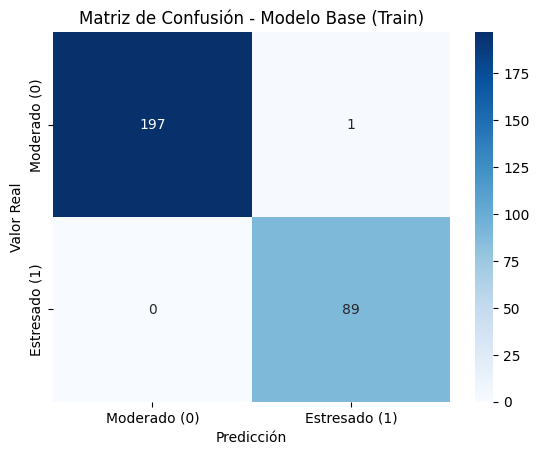

Verdaderos Negativos (TN): 197 (Predijo 'Moderado' y era 'Moderado')
Falsos Positivos   (FP): 1 (Predijo 'Estresado' y era 'Moderado')
Falsos Negativos   (FN): 0 (Predijo 'Moderado' y era 'Estresado')
Verdaderos Positivos (TP): 89 (Predijo 'Estresado' y era 'Estresado')

--- Métricas Calculadas (Train) ---
Precision:   0.9889
Recall (Sensibilidad): 1.0000
Specificity: 0.9949
F1-Score:    0.9944

--- Reporte de Clasificación (Train) ---
               precision    recall  f1-score   support

 Moderado (0)       1.00      0.99      1.00       198
Estresado (1)       0.99      1.00      0.99        89

     accuracy                           1.00       287
    macro avg       0.99      1.00      1.00       287
 weighted avg       1.00      1.00      1.00       287



In [4]:
print("\n--- Paso 3: Métricas del Modelo Base (sobre datos de TRAIN) ---")

# 1. Matriz de Confusión
cm_lr = confusion_matrix(y_train, y_pred_train_lr)
print(f"Matriz de Confusión (Train):\n{cm_lr}\n")

# Visualizar la Matriz de Confusión
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Moderado (0)', 'Estresado (1)'], 
            yticklabels=['Moderado (0)', 'Estresado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - Modelo Base (Train)')
plt.show()

# 2. Extraer TN, FP, FN, TP
tn, fp, fn, tp = cm_lr.ravel()
print(f"Verdaderos Negativos (TN): {tn} (Predijo 'Moderado' y era 'Moderado')")
print(f"Falsos Positivos   (FP): {fp} (Predijo 'Estresado' y era 'Moderado')")
print(f"Falsos Negativos   (FN): {fn} (Predijo 'Moderado' y era 'Estresado')")
print(f"Verdaderos Positivos (TP): {tp} (Predijo 'Estresado' y era 'Estresado')\n")

# 3. Calcular Métricas
# Precision: De todos los que predijo como 'Estresado', ¿cuántos acertó?
precision = precision_score(y_train, y_pred_train_lr, zero_division=0)
# Recall (Sensitivity): De todos los que *realmente* eran 'Estresado', ¿cuántos encontró?
recall = recall_score(y_train, y_pred_train_lr, zero_division=0)
# F1-Score: Media armónica de Precision y Recall
f1 = f1_score(y_train, y_pred_train_lr, zero_division=0)
# Specificity: De todos los que *realmente* eran 'Moderado', ¿cuántos encontró?
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"--- Métricas Calculadas (Train) ---")
print(f"Precision:   {precision:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}\n")

# 4. Reporte de Clasificación (Resumen)
print("--- Reporte de Clasificación (Train) ---")
print(classification_report(y_train, y_pred_train_lr, target_names=['Moderado (0)', 'Estresado (1)'], zero_division=0))

In [5]:
print("\n--- Paso 4: Entrenar y Comparar 4 Modelos (evaluados en TEST) ---")

# 1. Definir los modelos que vamos a probar
models = {
    "Regresión Logística": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(random_state=42, probability=True) # probability=True es útil para la UI
}

# 2. Almacenar resultados
results_list = []

print("Entrenando y evaluando modelos en el set de PRUEBA...")

for name, model in models.items():
    # Crear el pipeline completo para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Entrenar en TODO el set de train
    pipeline.fit(X_train_featured, y_train)
    
    # Predecir en el set de TEST
    y_pred_test = pipeline.predict(X_test_featured)
    
    # Calcular métricas en TEST
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0) # Sensitivity
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    
    # Calcular Specificity
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Guardar resultados
    results_list.append({
        "Modelo": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sen)": recall,
        "F1-Score": f1,
        "Specificity": specificity
    })

# 3. Crear y mostrar la tabla de resultados
results_df = pd.DataFrame(results_list).set_index("Modelo")

print("\n--- Tabla Comparativa de Métricas (TEST) ---")
display(results_df)


--- Paso 4: Entrenar y Comparar 4 Modelos (evaluados en TEST) ---
Entrenando y evaluando modelos en el set de PRUEBA...

--- Tabla Comparativa de Métricas (TEST) ---


,Accuracy,Precision,Recall (Sen),F1-Score,Specificity
Modelo,,,,,
Regresión Logística,0.972222,0.954545,0.954545,0.954545,0.98
Random Forest,0.986111,1.000000,0.954545,0.976744,1.00
Gradient Boosting,1.000000,1.000000,1.000000,1.000000,1.00
Support Vector Machine (SVM),0.972222,0.954545,0.954545,0.954545,0.98


In [6]:
print("\n--- Paso 6: Análisis de Error (usando Gradient Boosting) ---")

# 1. Crear y entrenar el pipeline del MEJOR modelo
# (Asegúrate de cambiar esto si tu mejor modelo fue otro)
best_model_name = "Gradient Boosting"
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

best_model_pipeline.fit(X_train_featured, y_train)
y_pred_best = best_model_pipeline.predict(X_test_featured)

# 2. Crear un DataFrame con los datos de prueba, valores reales y predicciones
error_df = X_test_featured.copy()
error_df['Actual_Stress'] = y_test
error_df['Predicted_Stress'] = y_pred_best

# 3. Mapear 0 y 1 de nuevo a texto para que sea más fácil de leer
map_inv = {1: 'ESTRESADO', 0: 'ESTRES_MODERADO'}
error_df['Actual_Stress'] = error_df['Actual_Stress'].map(map_inv)
error_df['Predicted_Stress'] = error_df['Predicted_Stress'].map(map_inv)

# 4. Filtrar solo los Falsos Negativos (el peor error)
fn_errors = error_df[
    (error_df['Actual_Stress'] == 'ESTRESADO') & 
    (error_df['Predicted_Stress'] == 'ESTRES_MODERADO')
]

print(f"El modelo ({best_model_name}) tuvo {len(fn_errors)} Falsos Negativos (los peores errores) en el set de prueba.")
print("Mostrando estos errores:")
display(fn_errors)

# --- Explicación del Análisis de Error (Ejemplo) ---
print("\n--- Cómo analizar estos errores ---")
print("Observa la Fila 0 (o cualquier fila de arriba):")
print("1. La persona estaba 'ESTRESADA' (Actual), pero el modelo dijo 'MODERADO' (Predicted).")
print("2. Mira sus características: 'Quality of Sleep' = 6, 'Sleep Duration' = 6.2, 'Sleep Disorder' = 'None'.")
print("3. Explicación posible: El modelo aprendió que tener 'Sleep Disorder' = 'None' es un fuerte indicador de estrés 'Moderado'.")
print("   Aunque su calidad y duración de sueño eran bajas (6 y 6.2, típicos de estrés), el 'None' en el trastorno pudo")
print("   confundir al modelo y darle más peso, llevando a la predicción incorrecta.")


--- Paso 6: Análisis de Error (usando Gradient Boosting) ---
El modelo (Gradient Boosting) tuvo 0 Falsos Negativos (los peores errores) en el set de prueba.
Mostrando estos errores:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,Actual_Stress,Predicted_Stress



--- Cómo analizar estos errores ---
Observa la Fila 0 (o cualquier fila de arriba):
1. La persona estaba 'ESTRESADA' (Actual), pero el modelo dijo 'MODERADO' (Predicted).
2. Mira sus características: 'Quality of Sleep' = 6, 'Sleep Duration' = 6.2, 'Sleep Disorder' = 'None'.
3. Explicación posible: El modelo aprendió que tener 'Sleep Disorder' = 'None' es un fuerte indicador de estrés 'Moderado'.
   Aunque su calidad y duración de sueño eran bajas (6 y 6.2, típicos de estrés), el 'None' en el trastorno pudo
   confundir al modelo y darle más peso, llevando a la predicción incorrecta.


In [7]:
print("\n--- Paso 7: Guardar Modelo y Crear UI ---")

# 1. Guardar el pipeline completo
model_filename = 'stress_model_pipeline.pkl'
joblib.dump(best_model_pipeline, model_filename)

print(f"Pipeline del modelo '{best_model_name}' guardado como '{model_filename}'")


--- Paso 7: Guardar Modelo y Crear UI ---
Pipeline del modelo 'Gradient Boosting' guardado como 'stress_model_pipeline.pkl'
